In [26]:
from datetime import datetime
import datetime as dt
import time
from subgrounds.subgraph import SyntheticField, FieldPath
from subgrounds.subgrounds import Subgrounds
import pandas as pd
import duckdb as db
import seaborn as sns
import matplotlib.pyplot as plt
import IPython as ip
import  os as os


****************************************************************************************************************
****************************************************************************************************************
AS ALWAYS START WITH SILO
https://app.silo.finance/silo/0xf5ffabab8f9a6f4f6de1f0dd6e0820f68657d7db?screen=deposit

In [27]:
sg = Subgrounds()
apiKey = input('API Key, please')

In [28]:
#for when we save the files
file = input('Selet a folder to save output') ##enter your file path here - the file is in the repo "summary_stats.csv".
file = file+'/data'
if not os.path.exists(file):
    os.makedirs(file)

In [29]:
#SILO subgraph: https://gateway.thegraph.com/api/[api-key]/subgraphs/id/6rcT2GzBXGoi3ZMus92LHajM2b9qWGj7Z3dDhPxoUogB
silo = sg.load_api('https://gateway.thegraph.com/api/'+apiKey+'/subgraphs/id/6rcT2GzBXGoi3ZMus92LHajM2b9qWGj7Z3dDhPxoUogB')

In [30]:
oldBorrowsDb = pd.DataFrame()
siloFileName = file+'/siloFinanceOhmBorrows.csv'
try:
    oldBorrowsDb = pd.read_csv (siloFileName)
except:
    oldBorrowsDb = pd.DataFrame()
oldBorrowsDb.head(100)

""


In [31]:
maxSiloBorrowTimestamp = 0
try:
    maxSiloBorrowTimestamp = (max(0,oldBorrowsDb['transaction_timestamp'].max()))-5
except:
        maxSiloBorrowTimestamp = 0
maxSiloBorrowTimestamp = int(maxSiloBorrowTimestamp)
maxSiloBorrowTimestamp

0

In [32]:
##this captures the ENTIRE list of people who borrowed OHM
borrowTicker = 0
borrowslist = pd.DataFrame()
borrowsDb = pd.DataFrame()
borrowListLength = 1000
datediff = 0
now=0
daysAgo=0
daysLimit = 45
exit = False
while exit==False:
    skipValue = (borrowTicker)*(1000)
    borrows = silo.Query.borrows(
        orderBy='timestamp',
        orderDirection='desc',
        first=1000,
        skip = skipValue,
        where={ 'market': '0xf5ffabab8f9a6f4f6de1f0dd6e0820f68657d7db'
                ,'timestamp_gte': maxSiloBorrowTimestamp
                } #gOHM market

    )

    borrowslist = sg.query_df([
        borrows.id
        ,borrows.hash
        ,borrows.blockNumber
        ,borrows.timestamp
        ,borrows.account.id
        ,borrows.market.id
        ,borrows.market.protocol.id
        ,borrows.market.rates.rate
        ,borrows.market.rates.duration
        ,borrows.market.rates.side
        ,borrows.market.rates.type
        ,borrows.market.rates.token.id
        ,borrows.asset.name
        ,borrows.asset.symbol
        ,borrows.asset.decimals
        ,borrows.asset.lastPriceUSD
        ,borrows.amount
        ,borrows.amountUSD
    ])

    #borrowslist.sort_values(by=['borrows_timestamp'])

    borrowsDb=pd.concat([borrowsDb, borrowslist])
    recordTimestamp1 = borrowsDb.iat[borrowTicker,3]
    recordTimestamp = dt.datetime.fromtimestamp( recordTimestamp1 )
    now = (int(dt.datetime.utcnow().timestamp()))
    datediff=abs(int(now) - recordTimestamp1)
    daysAgo = int(datediff/86400)
    borrowsDbLength = len(borrowsDb)
    borrowListLength = len(borrowslist)
    recordID = borrowsDb.iat[borrowTicker,0]
    borrow = borrowsDb.iat[borrowTicker,1]
    print("iterations: ", borrowTicker, "Lines skipped: ",skipValue, "records collected: ", borrowListLength, " - latest recordID: ",borrow, " ", recordID , " - borrows DB length: ", borrowsDbLength, " - latest record from: ", recordTimestamp, daysAgo,"days ago")
    #print("iterations: ", borrowTicker, "records collected: ", borrowListLength, " - userdb length: ", borrowsDbLength)
    borrowTicker = borrowTicker+1

    if daysAgo>daysLimit: exit =True
    if borrowListLength<1000: exit =True

borrowsDb.columns = borrowsDb.columns.str.replace("borrows", "transaction")
borrowsDb['event']='borrow'
borrowsDb.drop_duplicates
print("Done. Total Records collected: ", borrowsDbLength)

iterations:  0 Lines skipped:  0 records collected:  18  - latest recordID:  0x6726ea9fa581ab0a5fa26b8a112c95e690500f446c39848b27cbba267986bcdd   0x6726ea9fa581ab0a5fa26b8a112c95e690500f446c39848b27cbba267986bcdd-230  - borrows DB length:  18  - latest record from:  2023-02-14 08:17:47 2 days ago
Done. Total Records collected:  18


In [33]:
borrowsDb.head(100)

,transaction_id,transaction_hash,transaction_blockNumber,transaction_timestamp,transaction_account_id,transaction_market_id,transaction_market_protocol_id,transaction_market_rates_rate,transaction_market_rates_duration,transaction_market_rates_side,transaction_market_rates_type,transaction_market_rates_token_id,transaction_asset_name,transaction_asset_symbol,transaction_asset_decimals,transaction_asset_lastPriceUSD,transaction_amount,transaction_amountUSD,event
0,0x6726ea9fa581ab0a5fa26b8a112c95e690500f446c39...,0x6726ea9fa581ab0a5fa26b8a112c95e690500f446c39...,16628130,1676391467,0x9b8b04b6f82cd5e1dae58ca3614d445f93defc5c,0xf5ffabab8f9a6f4f6de1f0dd6e0820f68657d7db,0xd998c35b7900b344bbbe6555cc11576942cf309d,1.123944,None,BORROWER,VARIABLE,0x64aa3364f17a4d01c6f1751fd97c2bd3d7e7f1d5,Olympus,OHM,9,10.592534,1480000000000,15782.938441,borrow
1,0x6726ea9fa581ab0a5fa26b8a112c95e690500f446c39...,0x6726ea9fa581ab0a5fa26b8a112c95e690500f446c39...,16628130,1676391467,0x9b8b04b6f82cd5e1dae58ca3614d445f93defc5c,0xf5ffabab8f9a6f4f6de1f0dd6e0820f68657d7db,0xd998c35b7900b344bbbe6555cc11576942cf309d,0.000000,None,BORROWER,VARIABLE,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,Olympus,OHM,9,10.592534,1480000000000,15782.938441,borrow
2,0x6726ea9fa581ab0a5fa26b8a112c95e690500f446c39...,0x6726ea9fa581ab0a5fa26b8a112c95e690500f446c39...,16628130,1676391467,0x9b8b04b6f82cd5e1dae58ca3614d445f93defc5c,0xf5ffabab8f9a6f4f6de1f0dd6e0820f68657d7db,0xd998c35b7900b344bbbe6555cc11576942cf309d,0.000000,None,BORROWER,VARIABLE,0xd7c9f0e536dc865ae858b0c0453fe76d13c3beac,Olympus,OHM,9,10.592534,1480000000000,15782.938441,borrow
3,0x6726ea9fa581ab0a5fa26b8a112c95e690500f446c39...,0x6726ea9fa581ab0a5fa26b8a112c95e690500f446c39...,16628130,1676391467,0x9b8b04b6f82cd5e1dae58ca3614d445f93defc5c,0xf5ffabab8f9a6f4f6de1f0dd6e0820f68657d7db,0xd998c35b7900b344bbbe6555cc11576942cf309d,0.090232,None,LENDER,VARIABLE,0x64aa3364f17a4d01c6f1751fd97c2bd3d7e7f1d5,Olympus,OHM,9,10.592534,1480000000000,15782.938441,borrow
4,0x6726ea9fa581ab0a5fa26b8a112c95e690500f446c39...,0x6726ea9fa581ab0a5fa26b8a112c95e690500f446c39...,16628130,1676391467,0x9b8b04b6f82cd5e1dae58ca3614d445f93defc5c,0xf5ffabab8f9a6f4f6de1f0dd6e0820f68657d7db,0xd998c35b7900b344bbbe6555cc11576942cf309d,0.000000,None,LENDER,VARIABLE,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,Olympus,OHM,9,10.592534,1480000000000,15782.938441,borrow
5,0x6726ea9fa581ab0a5fa26b8a112c95e690500f446c39...,0x6726ea9fa581ab0a5fa26b8a112c95e690500f446c39...,16628130,1676391467,0x9b8b04b6f82cd5e1dae58ca3614d445f93defc5c,0xf5ffabab8f9a6f4f6de1f0dd6e0820f68657d7db,0xd998c35b7900b344bbbe6555cc11576942cf309d,0.000000,None,LENDER,VARIABLE,0xd7c9f0e536dc865ae858b0c0453fe76d13c3beac,Olympus,OHM,9,10.592534,1480000000000,15782.938441,borrow
6,0x5fca09aaf64619a5d644ed392a64f5bd08b9e6b4b46e...,0x5fca09aaf64619a5d644ed392a64f5bd08b9e6b4b46e...,16627404,1676382743,0xc0b1f200aa9546ce074397bed7438bb2ec033877,0xf5ffabab8f9a6f4f6de1f0dd6e0820f68657d7db,0xd998c35b7900b344bbbe6555cc11576942cf309d,1.123944,None,BORROWER,VARIABLE,0x64aa3364f17a4d01c6f1751fd97c2bd3d7e7f1d5,Olympus,OHM,9,10.592534,175320427647,1812.167469,borrow
7,0x5fca09aaf64619a5d644ed392a64f5bd08b9e6b4b46e...,0x5fca09aaf64619a5d644ed392a64f5bd08b9e6b4b46e...,16627404,1676382743,0xc0b1f200aa9546ce074397bed7438bb2ec033877,0xf5ffabab8f9a6f4f6de1f0dd6e0820f68657d7db,0xd998c35b7900b344bbbe6555cc11576942cf309d,0.000000,None,BORROWER,VARIABLE,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,Olympus,OHM,9,10.592534,175320427647,1812.167469,borrow
8,0x5fca09aaf64619a5d644ed392a64f5bd08b9e6b4b46e...,0x5fca09aaf64619a5d644ed392a64f5bd08b9e6b4b46e...,16627404,1676382743,0xc0b1f200aa9546ce074397bed7438bb2ec033877,0xf5ffabab8f9a6f4f6de1f0dd6e0820f68657d7db,0xd998c35b7900b344bbbe6555cc11576942cf309d,0.000000,None,BORROWER,VARIABLE,0xd7c9f0e536dc865ae858b0c0453fe76d13c3beac,Olympus,OHM,9,10.592534,175320427647,1812.167469,borrow
9,0x5fca09aaf64619a5d644ed392a64f5bd08b9e6b4b46e...,0x5fca09aaf64619a5d644ed392a64f5bd08b9

In [34]:
#I swear I will figure out synthetic fields, but until then...
borrowsDbTimed = db.query("select "
               "    * "
                    " ,to_timestamp(transaction_timestamp::int) dateTime "
               "From borrowsDb "
                      "order by transaction_amountUSD desc"
               #"where lower(liquidityPools_name) like lower('%olympus%') "
                #    "or lower(pairs_token1_symbol) like lower('%OHM%')  "
               #" limit 100 "
               ).df()
borrowsDbTimed.head(100)

,transaction_id,transaction_hash,transaction_blockNumber,transaction_timestamp,transaction_account_id,transaction_market_id,transaction_market_protocol_id,transaction_market_rates_rate,transaction_market_rates_duration,transaction_market_rates_side,transaction_market_rates_type,transaction_market_rates_token_id,transaction_asset_name,transaction_asset_symbol,transaction_asset_decimals,transaction_asset_lastPriceUSD,transaction_amount,transaction_amountUSD,event,dateTime
0,0x6726ea9fa581ab0a5fa26b8a112c95e690500f446c39...,0x6726ea9fa581ab0a5fa26b8a112c95e690500f446c39...,16628130,1676391467,0x9b8b04b6f82cd5e1dae58ca3614d445f93defc5c,0xf5ffabab8f9a6f4f6de1f0dd6e0820f68657d7db,0xd998c35b7900b344bbbe6555cc11576942cf309d,1.123944,NaN,BORROWER,VARIABLE,0x64aa3364f17a4d01c6f1751fd97c2bd3d7e7f1d5,Olympus,OHM,9,10.592534,1480000000000,15782.938441,borrow,2023-02-14 16:17:47
1,0x6726ea9fa581ab0a5fa26b8a112c95e690500f446c39...,0x6726ea9fa581ab0a5fa26b8a112c95e690500f446c39...,16628130,1676391467,0x9b8b04b6f82cd5e1dae58ca3614d445f93defc5c,0xf5ffabab8f9a6f4f6de1f0dd6e0820f68657d7db,0xd998c35b7900b344bbbe6555cc11576942cf309d,0.000000,NaN,BORROWER,VARIABLE,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,Olympus,OHM,9,10.592534,1480000000000,15782.938441,borrow,2023-02-14 16:17:47
2,0x6726ea9fa581ab0a5fa26b8a112c95e690500f446c39...,0x6726ea9fa581ab0a5fa26b8a112c95e690500f446c39...,16628130,1676391467,0x9b8b04b6f82cd5e1dae58ca3614d445f93defc5c,0xf5ffabab8f9a6f4f6de1f0dd6e0820f68657d7db,0xd998c35b7900b344bbbe6555cc11576942cf309d,0.000000,NaN,BORROWER,VARIABLE,0xd7c9f0e536dc865ae858b0c0453fe76d13c3beac,Olympus,OHM,9,10.592534,1480000000000,15782.938441,borrow,2023-02-14 16:17:47
3,0x6726ea9fa581ab0a5fa26b8a112c95e690500f446c39...,0x6726ea9fa581ab0a5fa26b8a112c95e690500f446c39...,16628130,1676391467,0x9b8b04b6f82cd5e1dae58ca3614d445f93defc5c,0xf5ffabab8f9a6f4f6de1f0dd6e0820f68657d7db,0xd998c35b7900b344bbbe6555cc11576942cf309d,0.090232,NaN,LENDER,VARIABLE,0x64aa3364f17a4d01c6f1751fd97c2bd3d7e7f1d5,Olympus,OHM,9,10.592534,1480000000000,15782.938441,borrow,2023-02-14 16:17:47
4,0x6726ea9fa581ab0a5fa26b8a112c95e690500f446c39...,0x6726ea9fa581ab0a5fa26b8a112c95e690500f446c39...,16628130,1676391467,0x9b8b04b6f82cd5e1dae58ca3614d445f93defc5c,0xf5ffabab8f9a6f4f6de1f0dd6e0820f68657d7db,0xd998c35b7900b344bbbe6555cc11576942cf309d,0.000000,NaN,LENDER,VARIABLE,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,Olympus,OHM,9,10.592534,1480000000000,15782.938441,borrow,2023-02-14 16:17:47
5,0x6726ea9fa581ab0a5fa26b8a112c95e690500f446c39...,0x6726ea9fa581ab0a5fa26b8a112c95e690500f446c39...,16628130,1676391467,0x9b8b04b6f82cd5e1dae58ca3614d445f93defc5c,0xf5ffabab8f9a6f4f6de1f0dd6e0820f68657d7db,0xd998c35b7900b344bbbe6555cc11576942cf309d,0.000000,NaN,LENDER,VARIABLE,0xd7c9f0e536dc865ae858b0c0453fe76d13c3beac,Olympus,OHM,9,10.592534,1480000000000,15782.938441,borrow,2023-02-14 16:17:47
6,0x5fca09aaf64619a5d644ed392a64f5bd08b9e6b4b46e...,0x5fca09aaf64619a5d644ed392a64f5bd08b9e6b4b46e...,16627404,1676382743,0xc0b1f200aa9546ce074397bed7438bb2ec033877,0xf5ffabab8f9a6f4f6de1f0dd6e0820f68657d7db,0xd998c35b7900b344bbbe6555cc11576942cf309d,1.123944,NaN,BORROWER,VARIABLE,0x64aa3364f17a4d01c6f1751fd97c2bd3d7e7f1d5,Olympus,OHM,9,10.592534,175320427647,1812.167469,borrow,2023-02-14 13:52:23
7,0x5fca09aaf64619a5d644ed392a64f5bd08b9e6b4b46e...,0x5fca09aaf64619a5d644ed392a64f5bd08b9e6b4b46e...,16627404,1676382743,0xc0b1f200aa9546ce074397bed7438bb2ec033877,0xf5ffabab8f9a6f4f6de1f0dd6e0820f68657d7db,0xd998c35b7900b344bbbe6555cc11576942cf309d,0.000000,NaN,BORROWER,VARIABLE,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,Olympus,OHM,9,10.592534,175320427647,1812.167469,borrow,2023-02-14 13:52:23
8,0x5fca09aaf64619a5d644ed392a64f5bd08b9e6b4b46e...,0x5fca09aaf64619a5d644ed392a64f5bd08b9e6b4b46e...,16627404,1676382743,0xc0b1f200aa9546ce074397bed7438bb2ec033877,0xf5ffabab8f9a6f4f6de1f0dd6e0820f68657d7db,0xd998c35b7900b344bbbe6555cc11576942cf309d,0.000000,NaN,BORROWER,VARIABLE,0xd7c9f0e536dc865ae858b0c0453

In [35]:
borrowsDbTimed = pd.concat([oldBorrowsDb,borrowsDbTimed]).drop_duplicates().reset_index(drop=True)
borrowsDbTimed.drop_duplicates()
borrowsDbTimed = db.query("select "
               "    * "
               "From borrowsDbTimed "
                         "group by 1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20 "
                      "order by transaction_amountUSD desc "
               #"where lower(liquidityPools_name) like lower('%olympus%') "
                #    "or lower(pairs_token1_symbol) like lower('%OHM%')  "
               #" limit 100 "
               ).df()

borrowsDbTimed.head(100)

,transaction_id,transaction_hash,transaction_blockNumber,transaction_timestamp,transaction_account_id,transaction_market_id,transaction_market_protocol_id,transaction_market_rates_rate,transaction_market_rates_duration,transaction_market_rates_side,transaction_market_rates_type,transaction_market_rates_token_id,transaction_asset_name,transaction_asset_symbol,transaction_asset_decimals,transaction_asset_lastPriceUSD,transaction_amount,transaction_amountUSD,event,dateTime
0,0x6726ea9fa581ab0a5fa26b8a112c95e690500f446c39...,0x6726ea9fa581ab0a5fa26b8a112c95e690500f446c39...,16628130,1676391467,0x9b8b04b6f82cd5e1dae58ca3614d445f93defc5c,0xf5ffabab8f9a6f4f6de1f0dd6e0820f68657d7db,0xd998c35b7900b344bbbe6555cc11576942cf309d,1.123944,NaN,BORROWER,VARIABLE,0x64aa3364f17a4d01c6f1751fd97c2bd3d7e7f1d5,Olympus,OHM,9,10.592534,1480000000000,15782.938441,borrow,2023-02-14 16:17:47
1,0x6726ea9fa581ab0a5fa26b8a112c95e690500f446c39...,0x6726ea9fa581ab0a5fa26b8a112c95e690500f446c39...,16628130,1676391467,0x9b8b04b6f82cd5e1dae58ca3614d445f93defc5c,0xf5ffabab8f9a6f4f6de1f0dd6e0820f68657d7db,0xd998c35b7900b344bbbe6555cc11576942cf309d,0.000000,NaN,BORROWER,VARIABLE,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,Olympus,OHM,9,10.592534,1480000000000,15782.938441,borrow,2023-02-14 16:17:47
2,0x6726ea9fa581ab0a5fa26b8a112c95e690500f446c39...,0x6726ea9fa581ab0a5fa26b8a112c95e690500f446c39...,16628130,1676391467,0x9b8b04b6f82cd5e1dae58ca3614d445f93defc5c,0xf5ffabab8f9a6f4f6de1f0dd6e0820f68657d7db,0xd998c35b7900b344bbbe6555cc11576942cf309d,0.000000,NaN,BORROWER,VARIABLE,0xd7c9f0e536dc865ae858b0c0453fe76d13c3beac,Olympus,OHM,9,10.592534,1480000000000,15782.938441,borrow,2023-02-14 16:17:47
3,0x6726ea9fa581ab0a5fa26b8a112c95e690500f446c39...,0x6726ea9fa581ab0a5fa26b8a112c95e690500f446c39...,16628130,1676391467,0x9b8b04b6f82cd5e1dae58ca3614d445f93defc5c,0xf5ffabab8f9a6f4f6de1f0dd6e0820f68657d7db,0xd998c35b7900b344bbbe6555cc11576942cf309d,0.090232,NaN,LENDER,VARIABLE,0x64aa3364f17a4d01c6f1751fd97c2bd3d7e7f1d5,Olympus,OHM,9,10.592534,1480000000000,15782.938441,borrow,2023-02-14 16:17:47
4,0x6726ea9fa581ab0a5fa26b8a112c95e690500f446c39...,0x6726ea9fa581ab0a5fa26b8a112c95e690500f446c39...,16628130,1676391467,0x9b8b04b6f82cd5e1dae58ca3614d445f93defc5c,0xf5ffabab8f9a6f4f6de1f0dd6e0820f68657d7db,0xd998c35b7900b344bbbe6555cc11576942cf309d,0.000000,NaN,LENDER,VARIABLE,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,Olympus,OHM,9,10.592534,1480000000000,15782.938441,borrow,2023-02-14 16:17:47
5,0x6726ea9fa581ab0a5fa26b8a112c95e690500f446c39...,0x6726ea9fa581ab0a5fa26b8a112c95e690500f446c39...,16628130,1676391467,0x9b8b04b6f82cd5e1dae58ca3614d445f93defc5c,0xf5ffabab8f9a6f4f6de1f0dd6e0820f68657d7db,0xd998c35b7900b344bbbe6555cc11576942cf309d,0.000000,NaN,LENDER,VARIABLE,0xd7c9f0e536dc865ae858b0c0453fe76d13c3beac,Olympus,OHM,9,10.592534,1480000000000,15782.938441,borrow,2023-02-14 16:17:47
6,0x5fca09aaf64619a5d644ed392a64f5bd08b9e6b4b46e...,0x5fca09aaf64619a5d644ed392a64f5bd08b9e6b4b46e...,16627404,1676382743,0xc0b1f200aa9546ce074397bed7438bb2ec033877,0xf5ffabab8f9a6f4f6de1f0dd6e0820f68657d7db,0xd998c35b7900b344bbbe6555cc11576942cf309d,1.123944,NaN,BORROWER,VARIABLE,0x64aa3364f17a4d01c6f1751fd97c2bd3d7e7f1d5,Olympus,OHM,9,10.592534,175320427647,1812.167469,borrow,2023-02-14 13:52:23
7,0x5fca09aaf64619a5d644ed392a64f5bd08b9e6b4b46e...,0x5fca09aaf64619a5d644ed392a64f5bd08b9e6b4b46e...,16627404,1676382743,0xc0b1f200aa9546ce074397bed7438bb2ec033877,0xf5ffabab8f9a6f4f6de1f0dd6e0820f68657d7db,0xd998c35b7900b344bbbe6555cc11576942cf309d,0.000000,NaN,BORROWER,VARIABLE,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,Olympus,OHM,9,10.592534,175320427647,1812.167469,borrow,2023-02-14 13:52:23
8,0x5fca09aaf64619a5d644ed392a64f5bd08b9e6b4b46e...,0x5fca09aaf64619a5d644ed392a64f5bd08b9e6b4b46e...,16627404,1676382743,0xc0b1f200aa9546ce074397bed7438bb2ec033877,0xf5ffabab8f9a6f4f6de1f0dd6e0820f68657d7db,0xd998c35b7900b344bbbe6555cc11576942cf309d,0.000000,NaN,BORROWER,VARIABLE,0xd7c9f0e536dc865ae858b0c0453

In [62]:
siloBorrowEventsDbTimedClean = db.query("select "
                            " transaction_id"
                            " ,event "
                            ", transaction_hash "
                            ", transaction_blockNumber "
                            ", transaction_timestamp "
                            ", transaction_account_id "
                            ", transaction_market_id "
                            ", transaction_asset_name "
                            ", transaction_asset_symbol "
                            ", transaction_amount "
                            ", (transaction_amount::hugeint*1e-8) transactionReadableAmount "
                            ", transaction_amountUSD "
                            ", dateTime "
                            ", date_trunc('day', dateTime) calDate "
               "From borrowsDbTimed "
                         "group by"
                            " transaction_id"
                            " ,event "
                            ", transaction_hash "
                            ", transaction_blockNumber "
                            ", transaction_timestamp "
                            ", transaction_account_id "
                            ", transaction_market_id "
                            ", transaction_asset_name "
                            ", transaction_asset_symbol "
                            ", transaction_amount "
                            ", transaction_amountUSD "
                            ", dateTime "
                      "order by transaction_amountUSD desc "
               #"where lower(liquidityPools_name) like lower('%olympus%') "
                #    "or lower(pairs_token1_symbol) like lower('%OHM%')  "
               #" limit 100 "
               ).df()
siloBorrowEventsDbTimedClean.head(100)

,transaction_id,event,transaction_hash,transaction_blockNumber,transaction_timestamp,transaction_account_id,transaction_market_id,transaction_asset_name,transaction_asset_symbol,transaction_amount,transactionReadableAmount,transaction_amountUSD,dateTime,calDate
0,0x6726ea9fa581ab0a5fa26b8a112c95e690500f446c39...,borrow,0x6726ea9fa581ab0a5fa26b8a112c95e690500f446c39...,16628130,1676391467,0x9b8b04b6f82cd5e1dae58ca3614d445f93defc5c,0xf5ffabab8f9a6f4f6de1f0dd6e0820f68657d7db,Olympus,OHM,1480000000000,1.480000e+04,15782.938441,2023-02-14 16:17:47,2023-02-14
1,0x5fca09aaf64619a5d644ed392a64f5bd08b9e6b4b46e...,borrow,0x5fca09aaf64619a5d644ed392a64f5bd08b9e6b4b46e...,16627404,1676382743,0xc0b1f200aa9546ce074397bed7438bb2ec033877,0xf5ffabab8f9a6f4f6de1f0dd6e0820f68657d7db,Olympus,OHM,175320427647,1.753204e+03,1812.167469,2023-02-14 13:52:23,2023-02-14
2,0x84bd007387e25c8e55e116e740aa58c36c6925d04156...,borrow,0x84bd007387e25c8e55e116e740aa58c36c6925d04156...,16625573,1676360579,0xc0b1f200aa9546ce074397bed7438bb2ec033877,0xf5ffabab8f9a6f4f6de1f0dd6e0820f68657d7db,XAI Stablecoin,XAI,10100000000000000000,1.010000e+11,10.088297,2023-02-14 07:42:59,2023-02-14


In [37]:
path =file+'/siloFinanceOhmBorrows.csv'
siloBorrowEventsDbTimedClean.to_csv(path, index = False)

path =file+'/siloFinanceOhmBorrows_piped.csv'
siloBorrowEventsDbTimedClean.to_csv(path, index = False, sep='|')
print(path, 'file saved,', len(borrowsDbTimed),' records')

D:\Dropbox\Documents\Edgecaser LLC\Projects\Olympus\Econohmetrics\ohmBorrowing/data/siloFinanceOhmBorrows_piped.csv file saved, 18  records


SILO DEPOSITS

In [38]:
oldDepositsDb = pd.DataFrame()
siloFileName = file+'/siloFinanceOhmDeposits.csv'
try:
    oldDepositsDb = pd.read_csv (siloFileName)
except:
    oldDepositsDb = pd.DataFrame()
oldDepositsDb.head(10)

""


In [39]:
maxSiloDepositTimestamp = 0
try:
    maxSiloDepositTimestamp = (max(0,oldDepositsDb['transaction_timestamp'].max()))-5
except:
        maxSiloDepositTimestamp = 0
maxSiloDepositTimestamp = int(maxSiloDepositTimestamp)
maxSiloDepositTimestamp

0

In [40]:
#this tracks the ENTIRE list of events for depositing OHM for lending
depositTicker = 0
depositslist = pd.DataFrame()
depositsDb = pd.DataFrame()
depositListLength = 1000
datediff = 0
now=0
daysAgo=0
daysLimit = 45
exit = False
while exit==False:
    skipValue = (depositTicker)*(1000)
    deposits = silo.Query.deposits(
        orderBy='timestamp',
        orderDirection='desc',
        first=1000,
        skip = skipValue,
        where={ 'market': '0xf5ffabab8f9a6f4f6de1f0dd6e0820f68657d7db' #gOHM market
                ,'timestamp_gte': maxSiloDepositTimestamp
                }


    )

    depositslist = sg.query_df([
        deposits.id
        ,deposits.hash
        ,deposits.blockNumber
        ,deposits.timestamp
        ,deposits.account.id
        ,deposits.market.id
        ,deposits.market.protocol.id
        ,deposits.market.rates.rate
        ,deposits.market.rates.duration
        ,deposits.market.rates.side
        ,deposits.market.rates.type
        ,deposits.market.rates.token.id
        ,deposits.asset.name
        ,deposits.asset.symbol
        ,deposits.asset.decimals
        ,deposits.asset.lastPriceUSD
        ,deposits.amount
        ,deposits.amountUSD
    ])

    #depositslist.sort_values(by=['deposits_timestamp'])

    depositsDb=pd.concat([depositsDb, depositslist])
    recordTimestamp1 = depositsDb.iat[depositTicker,3]
    recordTimestamp = dt.datetime.fromtimestamp( recordTimestamp1 )
    now = (int(dt.datetime.utcnow().timestamp()))
    datediff=abs(int(now) - recordTimestamp1)
    daysAgo = int(datediff/86400)
    depositsDbLength = len(depositsDb)
    depositListLength = len(depositslist)
    recordID = depositsDb.iat[depositTicker,0]
    deposit = depositsDb.iat[depositTicker,1]
    print("iterations: ", depositTicker, "Lines skipped: ",skipValue, "records collected: ", depositListLength, " - latest recordID: ",deposit, " ", recordID , " - deposits DB length: ", depositsDbLength, " - latest record from: ", recordTimestamp, daysAgo,"days ago")
    #print("iterations: ", depositTicker, "records collected: ", depositListLength, " - userdb length: ", depositsDbLength)
    depositTicker = depositTicker+1
    if daysAgo>daysLimit: exit =True
    if depositListLength<1000: exit =True

#depositsDb.sort_values(by=['deposits_timestamp'])

depositsDb.columns = depositsDb.columns.str.replace("deposits", "transaction")
depositsDb['event']='deposit'
depositsDb.drop_duplicates
print("Done. Total Records collected: ", depositsDbLength)

iterations:  0 Lines skipped:  0 records collected:  60  - latest recordID:  0x1c37394aaabc2445a66b61a360cf08ae096b7582e2edf84f44e917d97b9f9470   0x1c37394aaabc2445a66b61a360cf08ae096b7582e2edf84f44e917d97b9f9470-139  - deposits DB length:  60  - latest record from:  2023-02-16 21:28:11 0 days ago
Done. Total Records collected:  60


In [41]:
#I swear I will figure out synthetic fields, but until then...
depositsDbTimed = db.query("select "
               "    * "
                    " ,to_timestamp(transaction_timestamp::int) dateTime "
               "From depositsDb "
                           "where transaction_asset_symbol = 'OHM' "
               #"where lower(liquidityPools_name) like lower('%olympus%') "
                #    "or lower(pairs_token1_symbol) like lower('%OHM%')  "
               #" limit 100 "
               ).df()
depositsDbTimed.head(100)

,transaction_id,transaction_hash,transaction_blockNumber,transaction_timestamp,transaction_account_id,transaction_market_id,transaction_market_protocol_id,transaction_market_rates_rate,transaction_market_rates_duration,transaction_market_rates_side,transaction_market_rates_type,transaction_market_rates_token_id,transaction_asset_name,transaction_asset_symbol,transaction_asset_decimals,transaction_asset_lastPriceUSD,transaction_amount,transaction_amountUSD,event,dateTime
0,0x1c37394aaabc2445a66b61a360cf08ae096b7582e2ed...,0x1c37394aaabc2445a66b61a360cf08ae096b7582e2ed...,16646360,1676611691,0x9b53bed0d62028c0fc5d2006c076cb33e6e6cecd,0xf5ffabab8f9a6f4f6de1f0dd6e0820f68657d7db,0xd998c35b7900b344bbbe6555cc11576942cf309d,1.123944,NaN,BORROWER,VARIABLE,0x64aa3364f17a4d01c6f1751fd97c2bd3d7e7f1d5,Olympus,OHM,9,10.592534,10000000000,105.925340,deposit,2023-02-17 05:28:11
1,0x1c37394aaabc2445a66b61a360cf08ae096b7582e2ed...,0x1c37394aaabc2445a66b61a360cf08ae096b7582e2ed...,16646360,1676611691,0x9b53bed0d62028c0fc5d2006c076cb33e6e6cecd,0xf5ffabab8f9a6f4f6de1f0dd6e0820f68657d7db,0xd998c35b7900b344bbbe6555cc11576942cf309d,0.000000,NaN,BORROWER,VARIABLE,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,Olympus,OHM,9,10.592534,10000000000,105.925340,deposit,2023-02-17 05:28:11
2,0x1c37394aaabc2445a66b61a360cf08ae096b7582e2ed...,0x1c37394aaabc2445a66b61a360cf08ae096b7582e2ed...,16646360,1676611691,0x9b53bed0d62028c0fc5d2006c076cb33e6e6cecd,0xf5ffabab8f9a6f4f6de1f0dd6e0820f68657d7db,0xd998c35b7900b344bbbe6555cc11576942cf309d,0.000000,NaN,BORROWER,VARIABLE,0xd7c9f0e536dc865ae858b0c0453fe76d13c3beac,Olympus,OHM,9,10.592534,10000000000,105.925340,deposit,2023-02-17 05:28:11
3,0x1c37394aaabc2445a66b61a360cf08ae096b7582e2ed...,0x1c37394aaabc2445a66b61a360cf08ae096b7582e2ed...,16646360,1676611691,0x9b53bed0d62028c0fc5d2006c076cb33e6e6cecd,0xf5ffabab8f9a6f4f6de1f0dd6e0820f68657d7db,0xd998c35b7900b344bbbe6555cc11576942cf309d,0.090232,NaN,LENDER,VARIABLE,0x64aa3364f17a4d01c6f1751fd97c2bd3d7e7f1d5,Olympus,OHM,9,10.592534,10000000000,105.925340,deposit,2023-02-17 05:28:11
4,0x1c37394aaabc2445a66b61a360cf08ae096b7582e2ed...,0x1c37394aaabc2445a66b61a360cf08ae096b7582e2ed...,16646360,1676611691,0x9b53bed0d62028c0fc5d2006c076cb33e6e6cecd,0xf5ffabab8f9a6f4f6de1f0dd6e0820f68657d7db,0xd998c35b7900b344bbbe6555cc11576942cf309d,0.000000,NaN,LENDER,VARIABLE,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,Olympus,OHM,9,10.592534,10000000000,105.925340,deposit,2023-02-17 05:28:11
5,0x1c37394aaabc2445a66b61a360cf08ae096b7582e2ed...,0x1c37394aaabc2445a66b61a360cf08ae096b7582e2ed...,16646360,1676611691,0x9b53bed0d62028c0fc5d2006c076cb33e6e6cecd,0xf5ffabab8f9a6f4f6de1f0dd6e0820f68657d7db,0xd998c35b7900b344bbbe6555cc11576942cf309d,0.000000,NaN,LENDER,VARIABLE,0xd7c9f0e536dc865ae858b0c0453fe76d13c3beac,Olympus,OHM,9,10.592534,10000000000,105.925340,deposit,2023-02-17 05:28:11
6,0xf9bbcc923182fb6406e97fce0f92c22c87a284d55812...,0xf9bbcc923182fb6406e97fce0f92c22c87a284d55812...,16627144,1676379599,0x245cc372c84b3645bf0ffe6538620b04a217988b,0xf5ffabab8f9a6f4f6de1f0dd6e0820f68657d7db,0xd998c35b7900b344bbbe6555cc11576942cf309d,1.123944,NaN,BORROWER,VARIABLE,0x64aa3364f17a4d01c6f1751fd97c2bd3d7e7f1d5,Olympus,OHM,9,10.592534,20000000000000,206726.334541,deposit,2023-02-14 12:59:59
7,0xf9bbcc923182fb6406e97fce0f92c22c87a284d55812...,0xf9bbcc923182fb6406e97fce0f92c22c87a284d55812...,16627144,1676379599,0x245cc372c84b3645bf0ffe6538620b04a217988b,0xf5ffabab8f9a6f4f6de1f0dd6e0820f68657d7db,0xd998c35b7900b344bbbe6555cc11576942cf309d,0.000000,NaN,BORROWER,VARIABLE,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,Olympus,OHM,9,10.592534,20000000000000,206726.334541,deposit,2023-02-14 12:59:59
8,0xf9bbcc923182fb6406e97fce0f92c22c87a284d55812...,0xf9bbcc923182fb6406e97fce0f92c22c87a284d55812...,16627144,1676379599,0x245cc372c84b3645bf0ffe6538620b04a217988b,0xf5ffabab8f9a6f4f6de1f0dd6e0820f68657d7db,0xd998c35b7900b344bbbe6555cc11576942cf309d,0.000000,NaN,BORROWER,VARIABLE,0xd7c9f0e536dc865ae858b0c0453fe76d13c

In [42]:
depositsDbTimed = pd.concat([oldDepositsDb,depositsDbTimed]).drop_duplicates().reset_index(drop=True)
depositsDbTimed.sort_values(['transaction_id','transaction_market_rates_rate'])
depositsDbTimed.drop_duplicates(keep='first' )

depositsDbTimed = db.query("select "
               "    * "
               "From depositsDbTimed "
                         "group by 1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20 "
                      "order by transaction_amountUSD desc "
               #"where lower(liquidityPools_name) like lower('%olympus%') "
                #    "or lower(pairs_token1_symbol) like lower('%OHM%')  "
               #" limit 100 "
               ).df()


depositsDbTimed.head(100)


,transaction_id,transaction_hash,transaction_blockNumber,transaction_timestamp,transaction_account_id,transaction_market_id,transaction_market_protocol_id,transaction_market_rates_rate,transaction_market_rates_duration,transaction_market_rates_side,transaction_market_rates_type,transaction_market_rates_token_id,transaction_asset_name,transaction_asset_symbol,transaction_asset_decimals,transaction_asset_lastPriceUSD,transaction_amount,transaction_amountUSD,event,dateTime
0,0xf9bbcc923182fb6406e97fce0f92c22c87a284d55812...,0xf9bbcc923182fb6406e97fce0f92c22c87a284d55812...,16627144,1676379599,0x245cc372c84b3645bf0ffe6538620b04a217988b,0xf5ffabab8f9a6f4f6de1f0dd6e0820f68657d7db,0xd998c35b7900b344bbbe6555cc11576942cf309d,1.123944,NaN,BORROWER,VARIABLE,0x64aa3364f17a4d01c6f1751fd97c2bd3d7e7f1d5,Olympus,OHM,9,10.592534,20000000000000,206726.334541,deposit,2023-02-14 12:59:59
1,0xf9bbcc923182fb6406e97fce0f92c22c87a284d55812...,0xf9bbcc923182fb6406e97fce0f92c22c87a284d55812...,16627144,1676379599,0x245cc372c84b3645bf0ffe6538620b04a217988b,0xf5ffabab8f9a6f4f6de1f0dd6e0820f68657d7db,0xd998c35b7900b344bbbe6555cc11576942cf309d,0.000000,NaN,BORROWER,VARIABLE,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,Olympus,OHM,9,10.592534,20000000000000,206726.334541,deposit,2023-02-14 12:59:59
2,0xf9bbcc923182fb6406e97fce0f92c22c87a284d55812...,0xf9bbcc923182fb6406e97fce0f92c22c87a284d55812...,16627144,1676379599,0x245cc372c84b3645bf0ffe6538620b04a217988b,0xf5ffabab8f9a6f4f6de1f0dd6e0820f68657d7db,0xd998c35b7900b344bbbe6555cc11576942cf309d,0.000000,NaN,BORROWER,VARIABLE,0xd7c9f0e536dc865ae858b0c0453fe76d13c3beac,Olympus,OHM,9,10.592534,20000000000000,206726.334541,deposit,2023-02-14 12:59:59
3,0xf9bbcc923182fb6406e97fce0f92c22c87a284d55812...,0xf9bbcc923182fb6406e97fce0f92c22c87a284d55812...,16627144,1676379599,0x245cc372c84b3645bf0ffe6538620b04a217988b,0xf5ffabab8f9a6f4f6de1f0dd6e0820f68657d7db,0xd998c35b7900b344bbbe6555cc11576942cf309d,0.090232,NaN,LENDER,VARIABLE,0x64aa3364f17a4d01c6f1751fd97c2bd3d7e7f1d5,Olympus,OHM,9,10.592534,20000000000000,206726.334541,deposit,2023-02-14 12:59:59
4,0xf9bbcc923182fb6406e97fce0f92c22c87a284d55812...,0xf9bbcc923182fb6406e97fce0f92c22c87a284d55812...,16627144,1676379599,0x245cc372c84b3645bf0ffe6538620b04a217988b,0xf5ffabab8f9a6f4f6de1f0dd6e0820f68657d7db,0xd998c35b7900b344bbbe6555cc11576942cf309d,0.000000,NaN,LENDER,VARIABLE,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,Olympus,OHM,9,10.592534,20000000000000,206726.334541,deposit,2023-02-14 12:59:59
5,0xf9bbcc923182fb6406e97fce0f92c22c87a284d55812...,0xf9bbcc923182fb6406e97fce0f92c22c87a284d55812...,16627144,1676379599,0x245cc372c84b3645bf0ffe6538620b04a217988b,0xf5ffabab8f9a6f4f6de1f0dd6e0820f68657d7db,0xd998c35b7900b344bbbe6555cc11576942cf309d,0.000000,NaN,LENDER,VARIABLE,0xd7c9f0e536dc865ae858b0c0453fe76d13c3beac,Olympus,OHM,9,10.592534,20000000000000,206726.334541,deposit,2023-02-14 12:59:59
6,0x1c37394aaabc2445a66b61a360cf08ae096b7582e2ed...,0x1c37394aaabc2445a66b61a360cf08ae096b7582e2ed...,16646360,1676611691,0x9b53bed0d62028c0fc5d2006c076cb33e6e6cecd,0xf5ffabab8f9a6f4f6de1f0dd6e0820f68657d7db,0xd998c35b7900b344bbbe6555cc11576942cf309d,1.123944,NaN,BORROWER,VARIABLE,0x64aa3364f17a4d01c6f1751fd97c2bd3d7e7f1d5,Olympus,OHM,9,10.592534,10000000000,105.925340,deposit,2023-02-17 05:28:11
7,0x1c37394aaabc2445a66b61a360cf08ae096b7582e2ed...,0x1c37394aaabc2445a66b61a360cf08ae096b7582e2ed...,16646360,1676611691,0x9b53bed0d62028c0fc5d2006c076cb33e6e6cecd,0xf5ffabab8f9a6f4f6de1f0dd6e0820f68657d7db,0xd998c35b7900b344bbbe6555cc11576942cf309d,0.000000,NaN,BORROWER,VARIABLE,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,Olympus,OHM,9,10.592534,10000000000,105.925340,deposit,2023-02-17 05:28:11
8,0x1c37394aaabc2445a66b61a360cf08ae096b7582e2ed...,0x1c37394aaabc2445a66b61a360cf08ae096b7582e2ed...,16646360,1676611691,0x9b53bed0d62028c0fc5d2006c076cb33e6e6cecd,0xf5ffabab8f9a6f4f6de1f0dd6e0820f68657d7db,0xd998c35b7900b344bbbe6555cc11576942cf309d,0.000000,NaN,BORROWER,VARIABLE,0xd7c9f0e536d

In [58]:
siloDepositEventsDbTimedClean = db.query("select "
                            " transaction_id"
                            " ,event "
                            ", transaction_hash "
                            ", transaction_blockNumber "
                            ", transaction_timestamp "
                            ", transaction_account_id "
                            ", transaction_market_id "
                            ", transaction_asset_name "
                            ", transaction_asset_symbol "
                            ", transaction_amount "
                            ", (transaction_amount::hugeint*1e-8) transactionReadableAmount "
                            ", transaction_amountUSD "
                            ", dateTime "
                            ", date_trunc('day', dateTime) calDate "
               "From depositsDbTimed "
                         "group by"
                            " transaction_id"
                            " ,event "
                            ", transaction_hash "
                            ", transaction_blockNumber "
                            ", transaction_timestamp "
                            ", transaction_account_id "
                            ", transaction_market_id "
                            ", transaction_asset_name "
                            ", transaction_asset_symbol "
                            ", transaction_amount "
                            ", transaction_amountUSD "
                            ", dateTime "
                      "order by transaction_amountUSD desc "
               #"where lower(liquidityPools_name) like lower('%olympus%') "
                #    "or lower(pairs_token1_symbol) like lower('%OHM%')  "
               #" limit 100 "
               ).df()
siloDepositEventsDbTimedClean.head(100)

,transaction_id,event,transaction_hash,transaction_blockNumber,transaction_timestamp,transaction_account_id,transaction_market_id,transaction_asset_name,transaction_asset_symbol,transaction_amount,transactionReadableAmount,transaction_amountUSD,dateTime,calDate
0,0xf9bbcc923182fb6406e97fce0f92c22c87a284d55812...,deposit,0xf9bbcc923182fb6406e97fce0f92c22c87a284d55812...,16627144,1676379599,0x245cc372c84b3645bf0ffe6538620b04a217988b,0xf5ffabab8f9a6f4f6de1f0dd6e0820f68657d7db,Olympus,OHM,20000000000000,200000.000000,206726.334541,2023-02-14 12:59:59,2023-02-14
1,0x1c37394aaabc2445a66b61a360cf08ae096b7582e2ed...,deposit,0x1c37394aaabc2445a66b61a360cf08ae096b7582e2ed...,16646360,1676611691,0x9b53bed0d62028c0fc5d2006c076cb33e6e6cecd,0xf5ffabab8f9a6f4f6de1f0dd6e0820f68657d7db,Olympus,OHM,10000000000,100.000000,105.925340,2023-02-17 05:28:11,2023-02-17
2,0x0aa351eb8ff1ca2bd6c4e65229f83c7e5b596d72c889...,deposit,0x0aa351eb8ff1ca2bd6c4e65229f83c7e5b596d72c889...,16625541,1676360171,0xc0b1f200aa9546ce074397bed7438bb2ec033877,0xf5ffabab8f9a6f4f6de1f0dd6e0820f68657d7db,Olympus,OHM,2514698283,25.146983,26.317329,2023-02-14 07:36:11,2023-02-14


In [44]:
path =file+'/siloFinanceOhmDeposits.csv'
siloDepositEventsDbTimedClean.to_csv(path, index = False)

path =file+'/siloFinanceOhmDeposits_piped.csv'
siloDepositEventsDbTimedClean.to_csv(path, index = False, sep='|')

print(path, 'file saved,', len(borrowsDbTimed),' records')

D:\Dropbox\Documents\Edgecaser LLC\Projects\Olympus\Econohmetrics\ohmBorrowing/data/siloFinanceOhmDeposits_piped.csv file saved, 18  records


[Text(0.5, 1.0, 'OHM deposited per day'), Text(0.5, 0, 'Date'), Text(0, 0.5, 'OHM')]


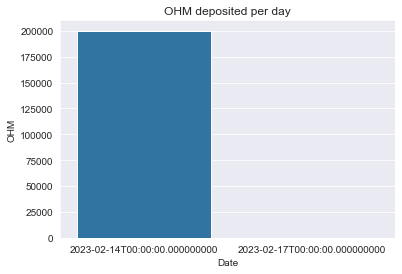

In [60]:
plt.rc("figure", figsize=(40, 20))
#sns.set_style("whitegrid")
plt.rc("font", size=50)


value_locked = siloDepositEventsDbTimedClean.groupby("calDate")["transactionReadableAmount"].agg("sum").reset_index()
plot_title = 'OHM deposited per day'
chart=sns.barplot(data=value_locked,y="transactionReadableAmount",x="calDate").set(title = plot_title, xlabel = 'Date', ylabel = 'OHM', )
print(chart)

[Text(0.5, 1.0, 'OHM borrowed per day'), Text(0.5, 0, 'Date'), Text(0, 0.5, 'OHM')]


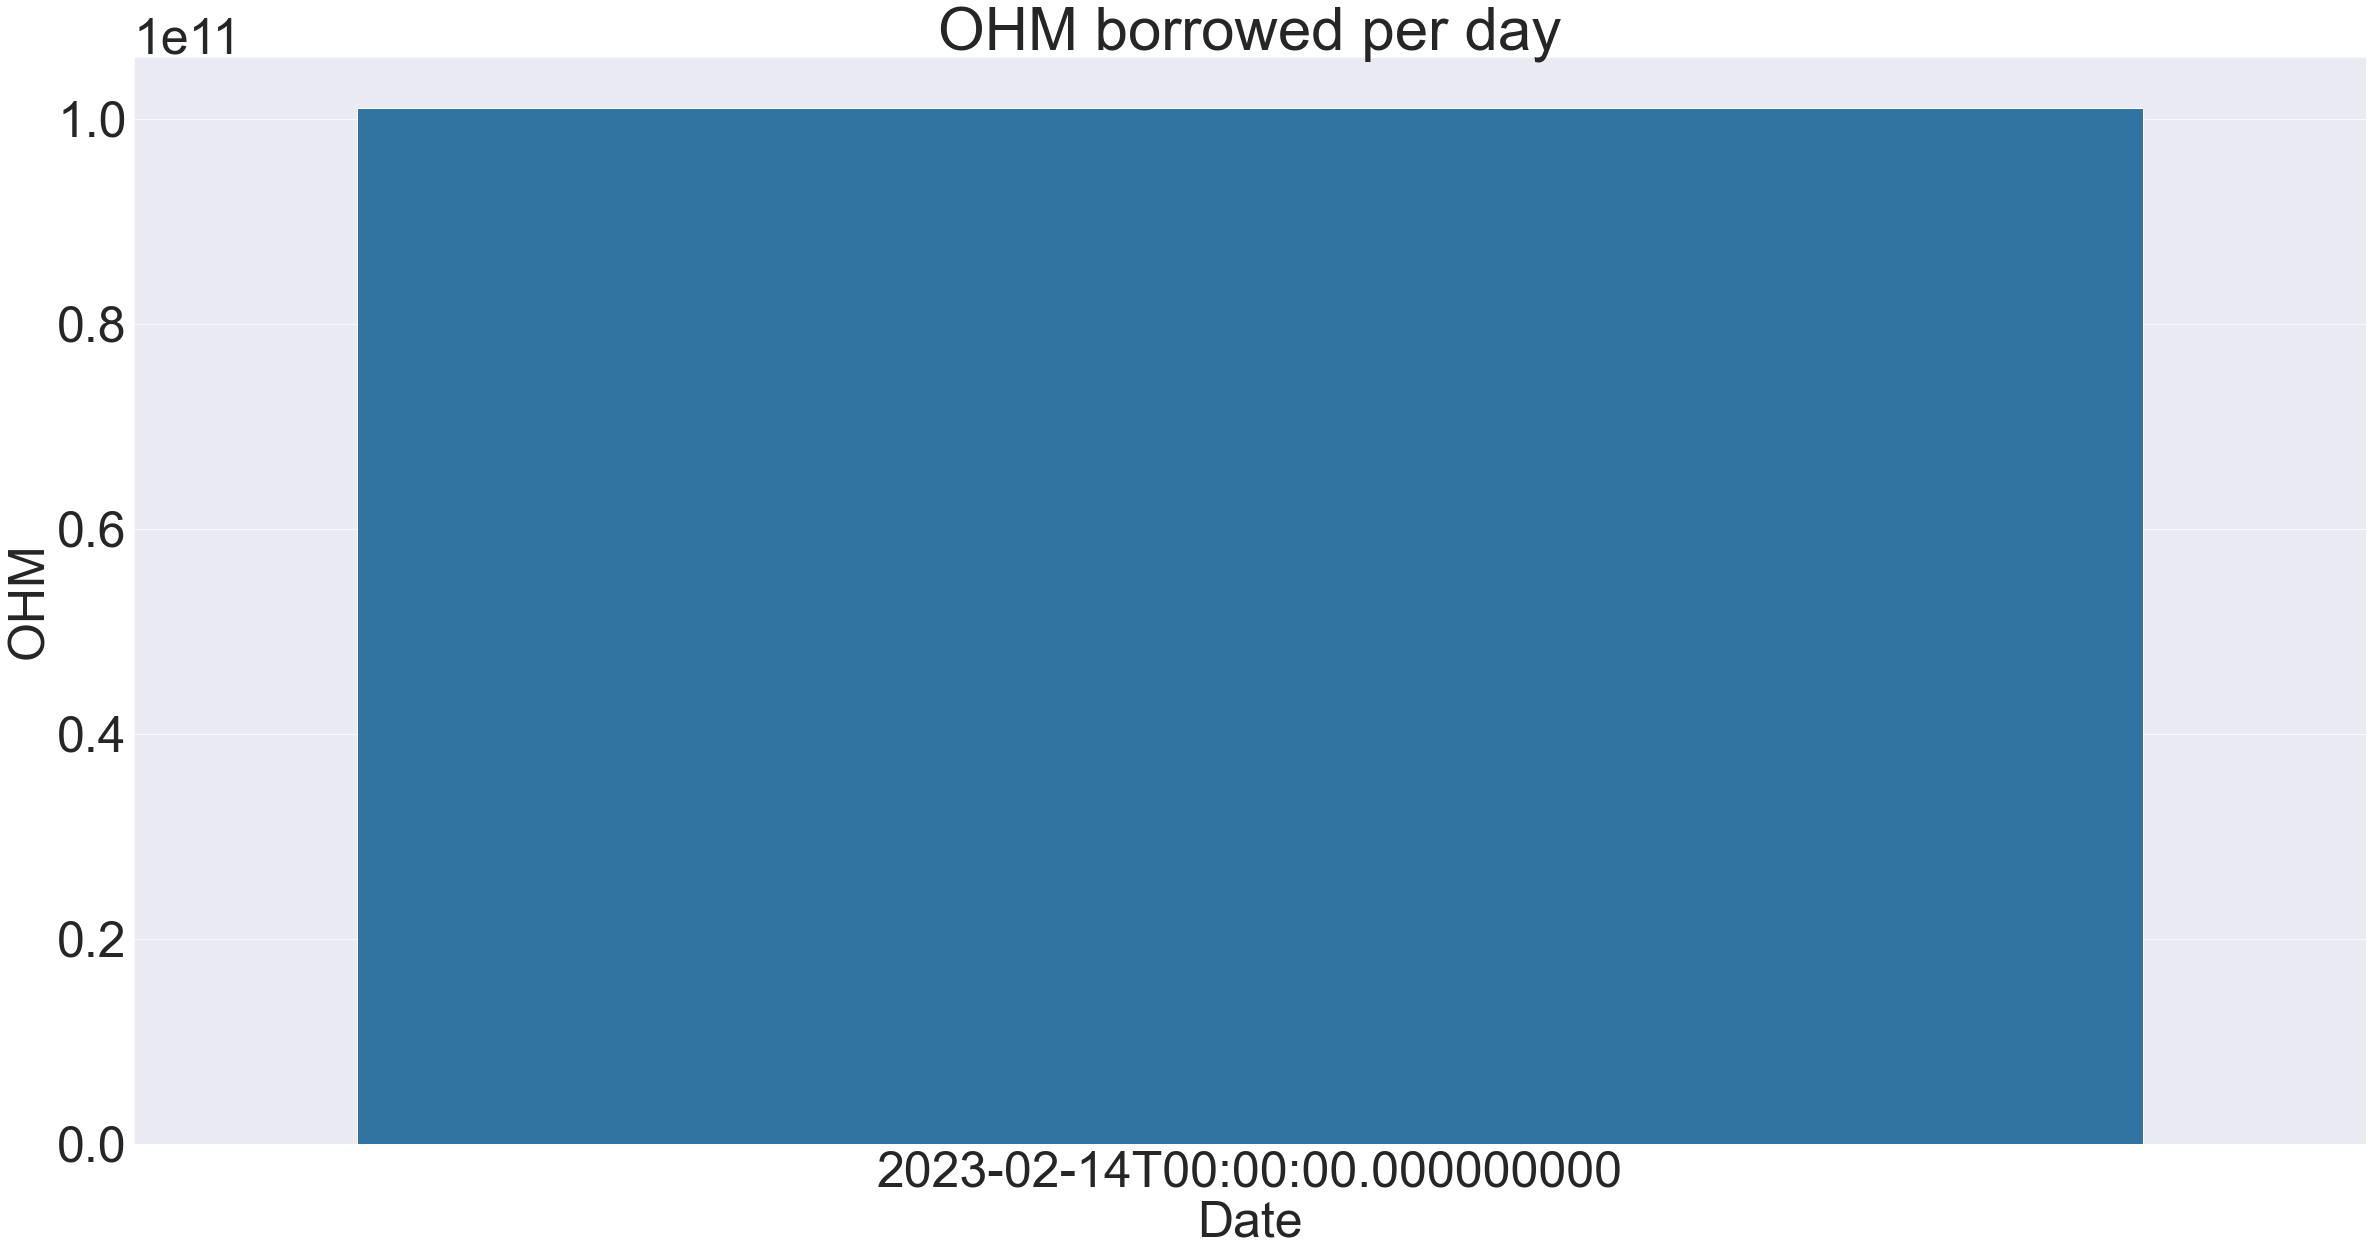

In [63]:
plt.rc("figure", figsize=(40, 20))
#sns.set_style("whitegrid")
plt.rc("font", size=50)


value_locked = siloBorrowEventsDbTimedClean.groupby("calDate")["transactionReadableAmount"].agg("sum").reset_index()
plot_title = 'OHM borrowed per day'
chart=sns.barplot(data=value_locked,y="transactionReadableAmount",x="calDate").set(title = plot_title, xlabel = 'Date', ylabel = 'OHM', )
print(chart)

In [67]:
totalBorrowed = sum(siloBorrowEventsDbTimedClean['transactionReadableAmount'])
print('There has been a total of',round(totalBorrowed,2),  'OHM borrowed cumulatively to date')

There has been a total of 101000016553.2 OHM borrowed cumulatively to date


In [68]:
totalBorrowedUSD = sum(siloBorrowEventsDbTimedClean['transaction_amountUSD'])
print('That\'s $',round(totalBorrowedUSD,2),  'USD at last price')

That's $ 17605.19 USD at last price


In [71]:
totalDeposited = sum(siloDepositEventsDbTimedClean['transactionReadableAmount'])
print('There has been a total of',round(totalDeposited,2),  'OHM deposited cumulatively to date')

There has been a total of 200125.15 OHM deposited cumulatively to date


In [73]:
totalBorrowedUSD = sum(siloDepositEventsDbTimedClean['transaction_amountUSD'])
print('That\'s $',round(totalBorrowedUSD,2),  'USD deposited at last price')

That's $ 206858.58 USD deposited at last price


****************************************************************************************************************
****************************************************************************************************************
LET'S LOOK AT THE EULER MARKET
https://app.euler.finance/market/0x64aa3364f17a4d01c6f1751fd97c2bd3d7e7f1d5
https://gateway.thegraph.com/api/[api-key]/subgraphs/id/8cLf29KxAedWLVaEqjV8qKomdwwXQxjptBZFrqWNH5u2

In [74]:
euler = sg.load_api('https://gateway.thegraph.com/api/'+apiKey+'/subgraphs/id/8cLf29KxAedWLVaEqjV8qKomdwwXQxjptBZFrqWNH5u2')

In [75]:
oldEulerBorrowsDb = pd.DataFrame()
EulerBorrowsFileName = file+'/eulerFinanceOhmBorrows.csv'
try:
    oldEulerBorrowsDb = pd.read_csv (EulerBorrowsFileName)
except:
    oldEulerBorrowsDb = pd.DataFrame()
oldEulerBorrowsDb.head(100)

""


In [76]:
maxEulerBorrowTimestamp = 0
try:
    maxEulerBorrowTimestamp = (max(0,oldBorrowsDb['transaction_timestamp'].max()))-5
except:
        maxEulerBorrowTimestamp = 0
maxEulerBorrowTimestamp = int(maxEulerBorrowTimestamp)
maxEulerBorrowTimestamp

0

In [115]:
borrows = euler.Query.deposits(
        orderBy='timestamp',
        orderDirection='desc',
        first=1000,
        skip = skipValue,
        where={ #'timestamp_gte': maxEulerBorrowTimestamp
                #,'hash': '0x301069fd24dd70d15cdcbebd4f076efe486a82f347240703adcb1713a6582e98'
                'market':'0x8a6622d293d5187a39f8dba7f6f1ae7fa527483b'
                ,'asset':'0x64aa3364f17a4d01c6f1751fd97c2bd3d7e7f1d5'
                }
    )

borrowslist = sg.query_df([
    borrows.id
    ,borrows.hash
    ,borrows.logIndex
    ,borrows.timestamp
    ,borrows.to
    ,borrows.asset
    ,borrows.amount
    ,borrows.amountUSD
    ,borrows.market
    #,borrows.market.lastPriceUSD
])
borrowslist.head(10)

,deposits_id,deposits_hash,deposits_logIndex,deposits_timestamp,deposits_to,deposits_asset_id,deposits_asset_name,deposits_asset_symbol,deposits_asset_decimals,deposits_asset_lastPriceUSD,...,deposits_market__dToken_id,deposits_market__totalBorrowBalance,deposits_market__dTokenExchangeRate,deposits_market__receivingRewards,deposits_market__weightedTotalBorrowUSD,deposits_market__borrowLastUpdateBlock,deposits_market__stakedAmount,deposits_market__weightedStakedAmount,deposits_market__stakeLastUpdateBlock,deposits_market__pricingType
0,0x301069fd24dd70d15cdcbebd4f076efe486a82f34724...,0x301069fd24dd70d15cdcbebd4f076efe486a82f34724...,199,1676615723,0x8a6622d293d5187a39f8dba7f6f1ae7fa527483b,0x64aa3364f17a4d01c6f1751fd97c2bd3d7e7f1d5,Olympus,OHM,9,10.592534,...,0x1cd63085053f3258b691cedfc5abfd62bb4bc05a,0,1.0,False,None,None,0,0,None,4
1,0xa7495eba745bd67279969c1b8687f816e0d83a60bf0c...,0xa7495eba745bd67279969c1b8687f816e0d83a60bf0c...,123,1676379695,0x8a6622d293d5187a39f8dba7f6f1ae7fa527483b,0x64aa3364f17a4d01c6f1751fd97c2bd3d7e7f1d5,Olympus,OHM,9,10.592534,...,0x1cd63085053f3258b691cedfc5abfd62bb4bc05a,0,1.0,False,None,None,0,0,None,4


In [77]:
##this captures the ENTIRE list of people who borrowed OHM
borrowTicker = 0
borrowslist = pd.DataFrame()
borrowsDb = pd.DataFrame()
borrowListLength = 1000
datediff = 0
now=0
daysAgo=0
daysLimit = 45
exit = False
while exit==False:
    skipValue = (borrowTicker)*(1000)
    borrows = euler.Query.borrows(
        orderBy='timestamp',
        orderDirection='desc',
        first=1000,
        skip = skipValue,
        where={ 'market': '0xf5ffabab8f9a6f4f6de1f0dd6e0820f68657d7db'
                ,'timestamp_gte': maxEulerBorrowTimestamp
                } #gOHM market

    )

    borrowslist = sg.query_df([
        borrows.id
        ,borrows.hash
        ,borrows.blockNumber
        ,borrows.timestamp
        ,borrows.account.id
        ,borrows.market.id
        ,borrows.market.protocol.id
        ,borrows.market.rates.rate
        ,borrows.market.rates.duration
        ,borrows.market.rates.side
        ,borrows.market.rates.type
        ,borrows.market.rates.token.id
        ,borrows.asset.name
        ,borrows.asset.symbol
        ,borrows.asset.decimals
        ,borrows.asset.lastPriceUSD
        ,borrows.amount
        ,borrows.amountUSD
    ])

    #borrowslist.sort_values(by=['borrows_timestamp'])

    borrowsDb=pd.concat([borrowsDb, borrowslist])
    recordTimestamp1 = borrowsDb.iat[borrowTicker,3]
    recordTimestamp = dt.datetime.fromtimestamp( recordTimestamp1 )
    now = (int(dt.datetime.utcnow().timestamp()))
    datediff=abs(int(now) - recordTimestamp1)
    daysAgo = int(datediff/86400)
    borrowsDbLength = len(borrowsDb)
    borrowListLength = len(borrowslist)
    recordID = borrowsDb.iat[borrowTicker,0]
    borrow = borrowsDb.iat[borrowTicker,1]
    print("iterations: ", borrowTicker, "Lines skipped: ",skipValue, "records collected: ", borrowListLength, " - latest recordID: ",borrow, " ", recordID , " - borrows DB length: ", borrowsDbLength, " - latest record from: ", recordTimestamp, daysAgo,"days ago")
    #print("iterations: ", borrowTicker, "records collected: ", borrowListLength, " - userdb length: ", borrowsDbLength)
    borrowTicker = borrowTicker+1

    if daysAgo>daysLimit: exit =True
    if borrowListLength<1000: exit =True

borrowsDb.columns = borrowsDb.columns.str.replace("borrows", "transaction")
borrowsDb['event']='borrow'
borrowsDb.drop_duplicates
print("Done. Total Records collected: ", borrowsDbLength)

KeyError: 'TypeMeta.ObjectMeta.field: no field named account for interface Borrow'